In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy.signal import sawtooth, square

shap.initjs()
sns.set_style("whitegrid")


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def custom_sawtooth(freq):
    return sawtooth(freq) + 1

def custom_square(freq):
    return (square(freq) + 1)/2

def custom_triangle(freq):
    return (sawtooth(freq, 0.5) + 1) / 2

stop = 4*2*np.pi / 2
num = 100
freq = np.linspace(start=0, stop=stop, num=num, endpoint=False)
timedelta = 1/stop/num

y_square = custom_square(freq)
y_square_df = [pd.DataFrame([y], columns=['V_input']) for y in y_square]

y_triangle = custom_triangle(freq)
y_triangle_df = [pd.DataFrame([y], columns=['V_input']) for y in y_triangle]

y_sawtooth = custom_sawtooth(freq)
y_sawtooth_df = [pd.DataFrame([y], columns=['V_input']) for y in y_sawtooth]

y_squaretooth = y_square + y_sawtooth

y_zero = np.zeros(shape=y_square.shape)



many_triangles = [custom_triangle(freq) for i in range(3)]
y_many_triangles = np.sum(many_triangles, axis=0)

y_many_df = [pd.DataFrame([y], columns=['Foo', 'Bar', 'Baz']) for y in zip(*many_triangles)]

In [3]:

class Circuit():

    def __init__(self, timedelta, R=None, C=None, V_stored=0) -> None:
        self.state_names = ['timedelta', 'R', 'C', 'V_stored']
        self.inputs_names = None
        self.fixed_parameters = ['timedelta', 'R', 'C']
        self.input = None
        self.R = R
        self.C = C
        self.V_stored = V_stored
        self.timedelta = timedelta
        self.shap_columns = None

    def set_shap_columns(self, df):
        self.shap_columns = df.columns

    @property
    def tau(self):
        return self.C * self.R

    def process(self, inputs):
        if isinstance(inputs, pd.DataFrame):
            inputs = inputs.values

        if not isinstance(inputs, np.ndarray):
            _inputs = np.array(inputs).reshape(1, -1)
        else:
            _inputs = inputs.reshape(1, -1)

        self.input = _inputs
        total_input = _inputs.sum()
        if total_input > self.V_stored:
            V_output = self.charge_circuit(total_input)
        else:
            V_output = self.discharge_circuit(total_input)

        return V_output

    def charge_circuit(self, V_input):
        V_output = V_input - (V_input - self.V_stored) * np.exp(-self.timedelta/self.tau)
        self.V_stored = V_output
        return V_output

    def discharge_circuit(self, V_input):
        V_output = V_input + (self.V_stored - V_input) * np.exp(-self.timedelta/self.tau)
        self.V_stored = V_output
        return V_output

    def twin_process(self, input):
        if isinstance(input, np.ndarray):
            input = pd.DataFrame(input.reshape(-1, len(self.shap_columns)), columns=self.shap_columns)

        if isinstance(input, pd.DataFrame):
            output = list()
            for i in range(input.shape[0]):
                _input = input.iloc[i]
                inner_variables = _input[self.state_names].to_dict()
                self.set_inner_variables(inner_variables)
                vish = list(set(input.columns) ^ set(inner_variables.keys()))
                _output = self.process(_input.loc[vish].values[0])
                output.append(_output)
            return np.array(output)

        else:
            raise Exception(f"Input type of {type(input).__name__} is not currently valid.")

    def twin_process_with_prefix(self, input):
        if isinstance(input, np.ndarray):
            input = pd.DataFrame(input.reshape(-1, len(self.shap_columns)), columns=self.shap_columns)

        if isinstance(input, pd.DataFrame):
            output = list()
            input_names = [col.split('input__')[1] for col in input.columns if col.startswith('input__')]
            state_names = [col.split('state__')[1] for col in input.columns if col.startswith('state__')]
            input.columns = input_names + state_names
            for i in range(input.shape[0]):
                _input = input.iloc[i]
                inner_variables = _input[state_names].to_dict()
                self.set_inner_variables(inner_variables)
                _output = self.process(_input[input_names].values)
                output.append(_output)
            return np.array(output)

        else:
            raise Exception(f"Input type of {type(input).__name__} is not currently valid.")

    def reset_state(self):
        kwargs = {key: getattr(self, key) for key in self.fixed_parameters}
        self.__init__(**kwargs)

    def set_inner_variables(self, variables: dict):
        for key in variables.keys():
            setattr(self, key, variables[key])

    def get_inner_variables(self):
        variables = {key: getattr(self, key) for key in self.state_names}
        return variables

    def get_inner_variables_with_prefix(self):
        variables = {f"state__{key}": getattr(self, key) for key in self.state_names}
        return variables

    def get_inputs(self):
        variables = {f'input_{i}': input for i, input in enumerate(self.input.flatten())}        
        return variables

    def get_inputs_with_prefix(self):
        if self.inputs_names == None:
            variables = {f'input__input_{i}': input for i, input in enumerate(self.input.flatten())}
        else:
            variables = {f'input__{name}': input for input, name in zip(self.input.flatten(), self.inputs_names)}
        return variables
    
    def set_inputs(self, inputs):
        if isinstance(inputs, pd.DataFrame):
            _inputs = inputs.values
            self.inputs_names = list(inputs.columns)

        if not isinstance(inputs, np.ndarray):
            _inputs = np.array(inputs).reshape(1, -1)
        else:
            _inputs = inputs.reshape(1, -1)

        self.input = _inputs


class Snapshot(Circuit):

    def __init__(self, *args, **kwargs) -> None:
        self.args = args
        self.kwargs = kwargs
        super().__init__(**kwargs)
        self.snapshots = []

    @property
    def snapshots_df(self):
        return pd.DataFrame(self.snapshots)

    @property
    def snapshots_list_series(self):
        return [pd.Series(snap) for snap in self.snapshots]

    def snap(self):
        inputs_snapshot = self.get_inputs_with_prefix()
        inner_variables_snapshot = self.get_inner_variables_with_prefix()
        snapshot = {**inputs_snapshot, **inner_variables_snapshot}
        self.snapshots.append(snapshot)
        return snapshot

    def process(self, input, error_check=False):
        self.set_inputs(input)
        snapshot = self.snap()
        output_A = super().process(self.input)
        if error_check:
            snapshot_df = pd.DataFrame([snapshot])
            circuit_B = Circuit(**self.kwargs)
            output_B = circuit_B.twin_process_with_prefix(snapshot_df)
            is_equal = np.isclose(a=output_A, b=output_B, rtol=1e-5)
            if not is_equal:
                raise Exception(f"Outputs are not equal. The variable output_A is {output_A} and output_B is {output_B}.")
            return snapshot_df


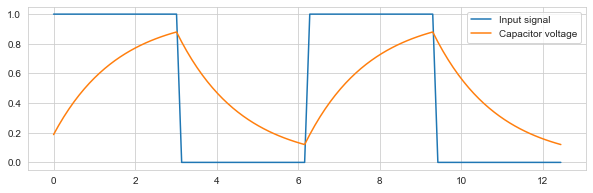

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


  0%|          | 0/100 [00:00<?, ?it/s]

In [4]:
R, C = 1e3, 1e-5
circuit = Circuit(timedelta, R, C)

v_output_1 = [circuit.process(V_i) for V_i in y_square]
v_output_1 = [circuit.process(np.array([V_i_1, V_i_2])) for V_i_1, V_i_2 in zip(y_square, y_zero)]
circuit.reset_state()

fig, axes = plt.subplots(nrows=1, figsize=(10, 3))

sns.lineplot(x=freq, y=y_square, label="Input signal", ax=axes)
sns.lineplot(x=freq, y=v_output_1, label="Capacitor voltage", ax=axes)
plt.show()


snapshotter = Snapshot(timedelta=timedelta, R=R, C=C)

for V_i in y_square:
    snapshotter.process(V_i, error_check=True)

snap_df = snapshotter.snapshots_df
snap_series = snapshotter.snapshots_list_series
circuit.set_shap_columns(snap_df)

X_train_summary = shap.kmeans(snap_df, 10)
ex = shap.KernelExplainer(circuit.twin_process_with_prefix, X_train_summary)
shap_values = ex.shap_values(snap_df)
# shap.force_plot(snap_df.iloc[1,:]['V_stored'], shap_values[1], snap_df.iloc[1,:])
shap.force_plot(snap_df.iloc[1,:]['state__V_stored'], shap_values[1], snap_df.iloc[1,:])


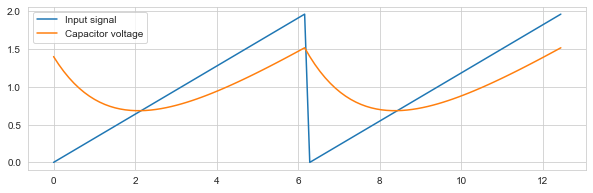

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
R, C = 1e3, 1e-5
circuit = Circuit(timedelta, R, C)

v_output_2 = [circuit.process(V_i) for V_i in y_sawtooth]
v_output_2 = [circuit.process(np.array([V_i_1, V_i_2])) for V_i_1, V_i_2 in zip(y_sawtooth, y_zero)]
circuit.reset_state()

fig, axes = plt.subplots(nrows=1, figsize=(10, 3))

sns.lineplot(x=freq, y=y_sawtooth, label="Input signal", ax=axes)
sns.lineplot(x=freq, y=v_output_2, label="Capacitor voltage", ax=axes)
plt.show()


snapshotter = Snapshot(timedelta=timedelta, R=R, C=C)

for V_i in y_sawtooth:
    snapshotter.process(V_i, error_check=True)

snap_df = snapshotter.snapshots_df
snap_series = snapshotter.snapshots_list_series
circuit.set_shap_columns(snap_df)

X_train_summary = shap.kmeans(snap_df, 10)
ex = shap.KernelExplainer(circuit.twin_process_with_prefix, X_train_summary)
shap_values = ex.shap_values(snap_df)
# shap.force_plot(snap_df.iloc[1,:]['V_stored'], shap_values[1], snap_df.iloc[1,:])
shap.force_plot(snap_df.iloc[1,:]['state__V_stored'], shap_values[1], snap_df.iloc[1,:])


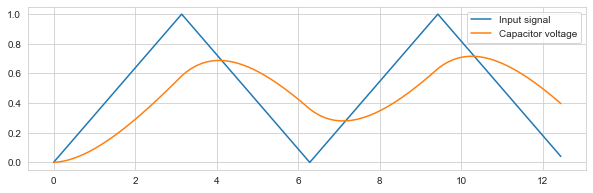

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


  0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
R, C = 1e3, 1e-5
circuit = Circuit(timedelta, R, C)

v_output_3 = [circuit.process(V_i) for V_i in y_triangle]
circuit.reset_state()

fig, axes = plt.subplots(nrows=1, figsize=(10, 3))

sns.lineplot(x=freq, y=y_triangle, label="Input signal", ax=axes)
sns.lineplot(x=freq, y=v_output_3, label="Capacitor voltage", ax=axes)
plt.show()


snapshotter = Snapshot(timedelta=timedelta, R=R, C=C)

for V_i in y_triangle:
    snapshotter.process(V_i, error_check=True)

snap_df = snapshotter.snapshots_df
snap_series = snapshotter.snapshots_list_series
circuit.set_shap_columns(snap_df)

X_train_summary = shap.kmeans(snap_df, 10)
ex = shap.KernelExplainer(circuit.twin_process_with_prefix, X_train_summary)
shap_values = ex.shap_values(snap_df)
# shap.force_plot(snap_df.iloc[1,:]['V_stored'], shap_values[1], snap_df.iloc[1,:])
shap.force_plot(snap_df.iloc[1,:]['state__V_stored'], shap_values[1], snap_df.iloc[1,:])


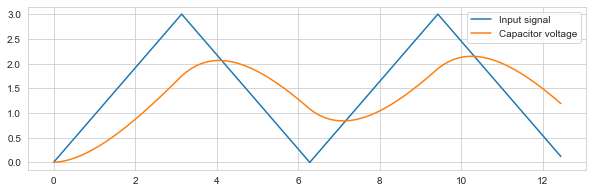

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


  0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
R, C = 1e3, 1e-5
circuit = Circuit(timedelta, R, C)

v_output_5 = [circuit.process(np.array([V_i])) for V_i in zip(*many_triangles)]
circuit.reset_state()

fig, axes = plt.subplots(nrows=1, figsize=(10, 3))

sns.lineplot(x=freq, y=y_many_triangles, label="Input signal", ax=axes)
sns.lineplot(x=freq, y=v_output_5, label="Capacitor voltage", ax=axes)
plt.show()


snapshotter = Snapshot(timedelta=timedelta, R=R, C=C)

for df in y_many_df:
    snapshotter.process(df, error_check=True)

snap_df = snapshotter.snapshots_df
snap_series = snapshotter.snapshots_list_series
circuit.set_shap_columns(snap_df)

X_train_summary = shap.kmeans(snap_df, 10)
ex = shap.KernelExplainer(circuit.twin_process_with_prefix, X_train_summary)
shap_values = ex.shap_values(snap_df)
# shap.force_plot(snap_df.iloc[1,:]['V_stored'], shap_values[1], snap_df.iloc[1,:])
shap.force_plot(snap_df.iloc[1,:]['state__V_stored'], shap_values[1], snap_df.iloc[1,:])


In [8]:

# snap_df

In [9]:

# ex = shap.KernelExplainer(circuit.twin_process, snap_df)
# shap_values = ex.shap_values(snap_df)
# shap.force_plot(ex.expected_value, shap_values[1], snap_df.iloc[1,:])


In [10]:
# shap_values = ex.shap_values(snap_df)
# shap.force_plot(ex.expected_value, shap_values, snap_df)


In [11]:
# snap_df[['Input', 'V_stored']].plot(figsize=(20, 4))